In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import acquire as a
import wrangle as w
from wrangle import scale_data
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = a.get_zillow_data()

In [3]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips
0,0.0,0.0,NaN,27516.0,NaN,NaN,6037.0
1,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
2,0.0,0.0,NaN,10.0,NaN,NaN,6037.0
3,0.0,0.0,NaN,2108.0,NaN,174.21,6037.0
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,6037.0


In [4]:
train, validate, test = w.wrangle_zillow()

In [5]:
train.head()

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,fips
397209,4,3.0,2287,741697,1997,8642.98,6059
920033,2,1.0,918,158409,1947,2381.94,6037
311353,4,2.5,1932,374400,1976,4738.44,6059
672101,3,3.0,2717,932755,1925,10822.44,6037
450335,3,2.5,1476,515000,1973,5925.12,6059


In [6]:
train_scaled, validate_scaled, test_scaled = w.scale_data(train, validate, test)


In [7]:
train_scaled.head()

,bedrooms,bathrooms,square_feet,tax_value,year_built,tax_amount,fips
397209,0.666667,0.500000,0.231400,741697,1997,0.132613,6059
920033,0.333333,0.166667,0.092823,158409,1947,0.036477,6037
311353,0.666667,0.416667,0.195465,374400,1976,0.072660,6059
672101,0.500000,0.500000,0.274927,932755,1925,0.166078,6037
450335,0.500000,0.416667,0.149307,515000,1973,0.090881,6059


In [8]:
X_train_scaled = train[['bedrooms', 'bathrooms', 'square_feet', 'tax_amount']] 
y_train = train['tax_value']

In [13]:
mm_scaler = MinMaxScaler()
mm_scaler.fit(validate[['bedrooms', 'bathrooms', 'square_feet', 'tax_amount']])
validate[['bedrooms', 'bathrooms', 'square_feet', 'tax_amount']] = mm_scaler.transform(validate[['bedrooms', 'bathrooms', 'square_feet', 'tax_amount']])
X_validate = validate.drop(columns=['tax_value', 'year_built', 'fips'])
X_train = train.drop(columns=['tax_value', 'year_built', 'fips'])
y_validate = validate['tax_value']

In [14]:
lm = LinearRegression()

In [15]:
lm.fit(X_train, y_train)

LinearRegression()

In [16]:
lm_preds = lm.predict(X_train)

In [21]:
preds_df = pd.DataFrame({'actual': y_train,
                         'lm_preds': lm_preds})
preds_df.head()

,actual,lm_preds
397209,741697,710909.991846
920033,158409,183115.572900
311353,374400,383272.767035
672101,932755,901318.639047
450335,515000,478193.132586


In [22]:
lm_rmse = sqrt(mean_squared_error(preds_df['lm_preds'], preds_df['actual']))
lm_rmse

67034.68671281275

In [23]:
lasso = LassoLars(alpha=0.1)

In [24]:
lasso.fit(X_train, y_train)

lasso_preds = lasso.predict(X_train)

In [25]:
preds_df['lasso_preds'] = lasso_preds
preds_df.head()

,actual,lm_preds,lasso_preds
397209,741697,710909.991846,711092.041234
920033,158409,183115.572900,182886.310534
311353,374400,383272.767035,383501.019791
672101,932755,901318.639047,900943.778485
450335,515000,478193.132586,478567.555320


In [26]:
lasso_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_preds']))
lasso_rmse

67035.8026488998

In [27]:
pf = PolynomialFeatures(degree=2)

pf.fit(X_train, y_train)

PolynomialFeatures()

In [28]:
X_polynomial = pf.transform(X_train)

In [29]:
lm2 = LinearRegression()

lm2.fit(X_polynomial, y_train)

LinearRegression()

In [30]:
preds_df['poly_preds'] = lm2.predict(X_polynomial)
preds_df.head()

,actual,lm_preds,lasso_preds,poly_preds
397209,741697,710909.991846,711092.041234,718390.063110
920033,158409,183115.572900,182886.310534,179293.076330
311353,374400,383272.767035,383501.019791,388118.767005
672101,932755,901318.639047,900943.778485,915552.492987
450335,515000,478193.132586,478567.555320,486773.873145


In [31]:
poly_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['poly_preds']))

poly_rmse

66135.62748433588

In [32]:
lasso2 = LassoLars(alpha=0.1)
lasso2.fit(X_polynomial, y_train)

LassoLars(alpha=0.1)

In [33]:
preds_df['lasso_poly'] = lasso2.predict(X_polynomial)
preds_df.head()

,actual,lm_preds,lasso_preds,poly_preds,lasso_poly
397209,741697,710909.991846,711092.041234,718390.063110,718702.200326
920033,158409,183115.572900,182886.310534,179293.076330,180249.634602
311353,374400,383272.767035,383501.019791,388118.767005,387755.362100
672101,932755,901318.639047,900943.778485,915552.492987,912023.530131
450335,515000,478193.132586,478567.555320,486773.873145,486335.534384


In [34]:
lassopoly_rmse = sqrt(mean_squared_error(preds_df['actual'], preds_df['lasso_poly']))
lassopoly_rmse

66166.22198536614

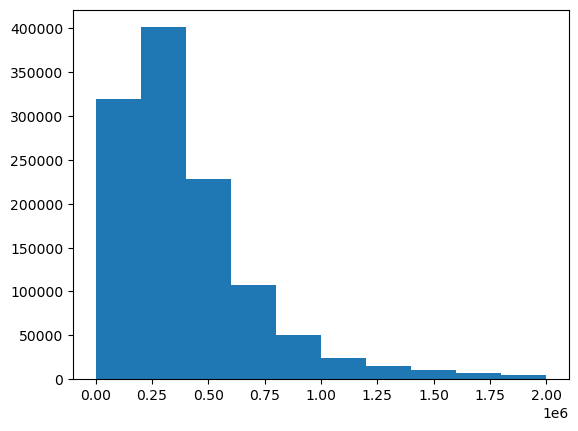

In [35]:
plt.hist(y_train)
plt.show()

In [36]:
tweedie = TweedieRegressor(power=0)

tweedie.fit(X_train, y_train)

TweedieRegressor(power=0)

In [37]:
preds_df['tweedie'] = tweedie.predict(X_train)
preds_df.head()

,actual,lm_preds,lasso_preds,poly_preds,lasso_poly,tweedie
397209,741697,710909.991846,711092.041234,718390.063110,718702.200326,712473.680485
920033,158409,183115.572900,182886.310534,179293.076330,180249.634602,181051.279049
311353,374400,383272.767035,383501.019791,388118.767005,387755.362100,384961.390051
672101,932755,901318.639047,900943.778485,915552.492987,912023.530131,899440.689075
450335,515000,478193.132586,478567.555320,486773.873145,486335.534384,479154.590572


In [38]:
tweedie_norm = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie']))
tweedie_norm

67062.43790268069

In [39]:
tweedie2 = TweedieRegressor(power=1)

tweedie2.fit(X_train, y_train)
preds_df['tweedie2'] = tweedie2.predict(X_train)

In [40]:
tweedie_poisson = sqrt(mean_squared_error(preds_df['actual'], preds_df['tweedie2']))
tweedie_poisson

313858.5430245682

In [41]:
pd.DataFrame({'model': ['linear', 'lasso', 'linear_poly', 'lasso_poly', 'tweedie_norm', 'tweedie_poisson'],
  'rmse': [lm_rmse, lasso_rmse, poly_rmse, lassopoly_rmse, tweedie_norm, tweedie_poisson]})

,model,rmse
0,linear,67034.686713
1,lasso,67035.802649
2,linear_poly,66135.627484
3,lasso_poly,66166.221985
4,tweedie_norm,67062.437903
5,tweedie_poisson,313858.543025


In [42]:
preds_df['baseline'] = y_train.mean()
preds_df.head()

,actual,lm_preds,lasso_preds,poly_preds,lasso_poly,tweedie,tweedie2,baseline
397209,741697,710909.991846,711092.041234,718390.063110,718702.200326,712473.680485,399082.324049,399082.324049
920033,158409,183115.572900,182886.310534,179293.076330,180249.634602,181051.279049,399082.324049,399082.324049
311353,374400,383272.767035,383501.019791,388118.767005,387755.362100,384961.390051,399082.324049,399082.324049
672101,932755,901318.639047,900943.778485,915552.492987,912023.530131,899440.689075,399082.324049,399082.324049
450335,515000,478193.132586,478567.555320,486773.873145,486335.534384,479154.590572,399082.324049,399082.324049


In [43]:
sqrt(mean_squared_error(preds_df['actual'], preds_df['baseline']))

313858.5430245682